# Feature Selection & Dimensionality Reduction

This notebook implements feature selection and dimensionality reduction to improve model performance.

**Current Issues:**
- 175 features (16 statistical + 159 EMD) - too many for the dataset size
- Models show overfitting (train R² 0.75-0.99 vs test R² -0.13 to 0.16)
- High-dimensional feature space may contain redundant information

**Goals:**
1. Identify most important features using Random Forest feature importance
2. Remove redundant EMD features (correlation analysis)
3. Apply PCA to reduce dimensionality while preserving variance
4. Compare different feature selection strategies
5. Retrain models with reduced features and compare performance

**Target:** Reduce from 175 features to 20-30 most important features


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path("/Users/siddhantaggarwal/Desktop/Battery_RUL").resolve()
sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Imports complete!")


✅ Imports complete!


In [2]:
# Load dataset
processed_dir = project_root / "data" / "processed"
df = pd.read_parquet(processed_dir / "rul_features_with_emd.parquet")

print(f"Dataset shape: {df.shape}")

# Filter out rows with NaN RUL
df_clean = df[df['RUL'].notna()].copy()
print(f"After removing NaN RUL: {len(df_clean)} rows")
print(f"RUL range: [{df_clean['RUL'].min():.1f}, {df_clean['RUL'].max():.1f}] cycles")

# Prepare features
exclude_cols = [
    'battery_id', 'filename', 'type', 'start_time', 'test_id', 'uid',
    'split', 'cycle_index', 'EOL_cycle', 'RUL', 'SOH', 'Capacity', 
    'Re', 'Rct', 'ambient_temperature'
]

feature_cols = [c for c in df_clean.columns if c not in exclude_cols]
print(f"\nTotal features: {len(feature_cols)}")

# Categorize features
emd_features = [c for c in feature_cols if '_imf' in c.lower()]
stat_features = [c for c in feature_cols if c not in emd_features]
print(f"  - Statistical features: {len(stat_features)}")
print(f"  - EMD features: {len(emd_features)}")

# Create feature matrix and target
X = df_clean[feature_cols].fillna(0)
y = df_clean['RUL'].values

# Split by battery (already done in dataset)
train_idx = df_clean['split'] == 'train'
test_idx = df_clean['split'] == 'test'

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")
print(f"Train RUL stats: mean={y_train.mean():.2f}, std={y_train.std():.2f}")


Dataset shape: (2750, 190)
After removing NaN RUL: 1408 rows
RUL range: [-107.0, 123.0] cycles

Total features: 175
  - Statistical features: 16
  - EMD features: 159

Train: 1158, Test: 250
Train RUL stats: mean=-0.25, std=44.31


## Step 1: Random Forest Feature Importance


In [3]:
# Train Random Forest to get feature importance
print("Training Random Forest for feature importance...")
rf_importance = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_importance.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✅ Feature importance calculated!")
print(f"\nTop 20 most important features:")
print(feature_importance.head(20).to_string(index=False))


Training Random Forest for feature importance...

✅ Feature importance calculated!

Top 20 most important features:
                  feature  importance
               coulomb_Ah    0.594527
             voltage_mean    0.108583
         current_mean_abs    0.039175
         current_imf1_std    0.028497
     temperature_imf1_min    0.026014
              current_std    0.017169
              voltage_max    0.017101
      voltage_imf1_energy    0.013256
              voltage_min    0.012764
   voltage_drop_rate_mean    0.011468
               duration_s    0.010166
    voltage_drop_rate_max    0.009475
              voltage_std    0.009072
                 temp_std    0.008442
current_imf6_energy_ratio    0.006240
         voltage_imf1_max    0.006198
          current_max_abs    0.005036
temperature_imf1_kurtosis    0.004532
                 temp_max    0.004437
                 temp_min    0.004084


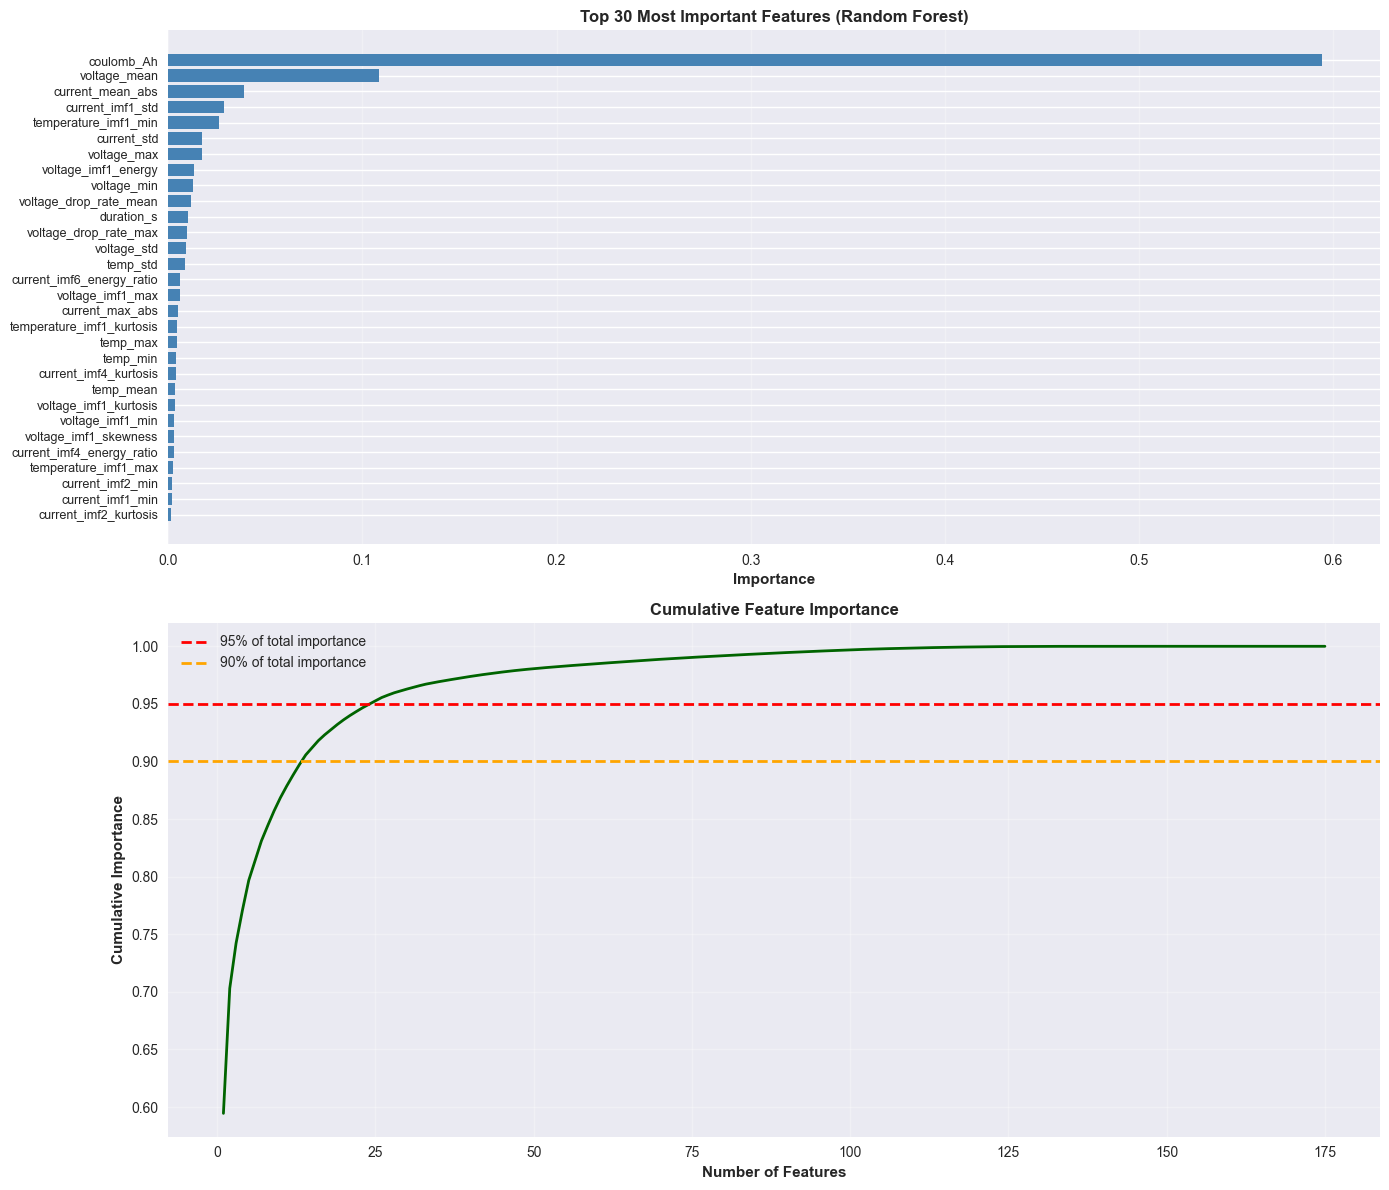


Features needed for 90% importance: 14
Features needed for 95% importance: 22


In [4]:
# Visualize feature importance
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top 30 features
top_n = 30
top_features = feature_importance.head(top_n)

axes[0].barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance', fontweight='bold')
axes[0].set_title(f'Top {top_n} Most Important Features (Random Forest)', fontweight='bold', fontsize=12)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Cumulative importance
cumulative_importance = feature_importance['importance'].cumsum()
axes[1].plot(range(1, len(cumulative_importance) + 1), cumulative_importance, linewidth=2, color='darkgreen')
axes[1].axhline(0.95, color='red', linestyle='--', linewidth=2, label='95% of total importance')
axes[1].axhline(0.90, color='orange', linestyle='--', linewidth=2, label='90% of total importance')
axes[1].set_xlabel('Number of Features', fontweight='bold')
axes[1].set_ylabel('Cumulative Importance', fontweight='bold')
axes[1].set_title('Cumulative Feature Importance', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of features needed for 90% and 95% importance
n_features_90 = (cumulative_importance >= 0.90).idxmax() + 1
n_features_95 = (cumulative_importance >= 0.95).idxmax() + 1
print(f"\nFeatures needed for 90% importance: {n_features_90}")
print(f"Features needed for 95% importance: {n_features_95}")


## Step 2: Remove Redundant EMD Features (Correlation Analysis)


In [5]:
# Analyze correlation among EMD features
X_train_emd = X_train[emd_features]
corr_matrix = X_train_emd.corr().abs()

# Find highly correlated feature pairs (correlation > 0.95)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.95:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"Found {len(high_corr_pairs)} highly correlated EMD feature pairs (correlation > 0.95)")
if len(high_corr_pairs) > 0:
    print("\nTop 10 most correlated pairs:")
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
    high_corr_df = high_corr_df.sort_values('Correlation', ascending=False)
    print(high_corr_df.head(10).to_string(index=False))


Found 68 highly correlated EMD feature pairs (correlation > 0.95)

Top 10 most correlated pairs:
            Feature 1                 Feature 2  Correlation
  voltage_imf6_energy     voltage_imf6_skewness          1.0
     voltage_imf6_std       voltage_imf6_energy          1.0
voltage_imf6_skewness voltage_imf6_energy_ratio          1.0
     voltage_imf6_std     voltage_imf6_skewness          1.0
  voltage_imf6_energy     voltage_imf6_kurtosis          1.0
     voltage_imf6_min voltage_imf6_energy_ratio          1.0
voltage_imf6_kurtosis voltage_imf6_energy_ratio          1.0
     voltage_imf6_std          voltage_imf6_max          1.0
     voltage_imf6_min      voltage_imf_corr_5_6          1.0
  voltage_imf6_energy voltage_imf6_energy_ratio          1.0


In [6]:
# Remove redundant features: keep feature with higher importance, remove the other
features_to_remove = set()
for feat1, feat2, corr in high_corr_pairs:
    # Get importance of both features
    imp1 = feature_importance[feature_importance['feature'] == feat1]['importance'].values[0]
    imp2 = feature_importance[feature_importance['feature'] == feat2]['importance'].values[0]
    
    # Remove the one with lower importance
    if imp1 < imp2:
        features_to_remove.add(feat1)
    else:
        features_to_remove.add(feat2)

print(f"\nRemoving {len(features_to_remove)} redundant EMD features")
if len(features_to_remove) > 0:
    print(f"Features to remove (first 20): {list(features_to_remove)[:20]}")

# Create reduced feature set (remove redundant EMD features)
features_after_redundancy_removal = [f for f in feature_cols if f not in features_to_remove]
print(f"\nFeatures after removing redundant EMD: {len(features_after_redundancy_removal)} (removed {len(features_to_remove)})")



Removing 30 redundant EMD features
Features to remove (first 20): ['temperature_imf5_min', 'temperature_imf5_max', 'temperature_imf6_max', 'temperature_imf2_energy_ratio', 'current_imf1_max', 'temperature_imf3_min', 'current_imf2_max', 'temperature_imf4_std', 'temperature_imf5_energy', 'voltage_imf3_min', 'voltage_imf6_skewness', 'voltage_imf6_min', 'temperature_imf6_std', 'temperature_imf2_max', 'temperature_imf3_max', 'voltage_imf6_std', 'temperature_imf1_max', 'voltage_imf_corr_5_6', 'voltage_imf1_std', 'temperature_imf1_std']

Features after removing redundant EMD: 145 (removed 30)


## Step 3: Apply PCA for Dimensionality Reduction


In [7]:
# Prepare data for PCA (use features after redundancy removal)
X_train_reduced = X_train[features_after_redundancy_removal]
X_test_reduced = X_test[features_after_redundancy_removal]

# Standardize features (required for PCA)
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train_reduced)
X_test_scaled = scaler_pca.transform(X_test_reduced)

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 90%, 95%, 99% variance
n_components_90 = (cumulative_variance >= 0.90).argmax() + 1
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1
n_components_99 = (cumulative_variance >= 0.99).argmax() + 1

print(f"PCA Analysis:")
print(f"  Components for 90% variance: {n_components_90}")
print(f"  Components for 95% variance: {n_components_95}")
print(f"  Components for 99% variance: {n_components_99}")
print(f"  Total components: {len(pca.components_)}")


PCA Analysis:
  Components for 90% variance: 44
  Components for 95% variance: 57
  Components for 99% variance: 82
  Total components: 145


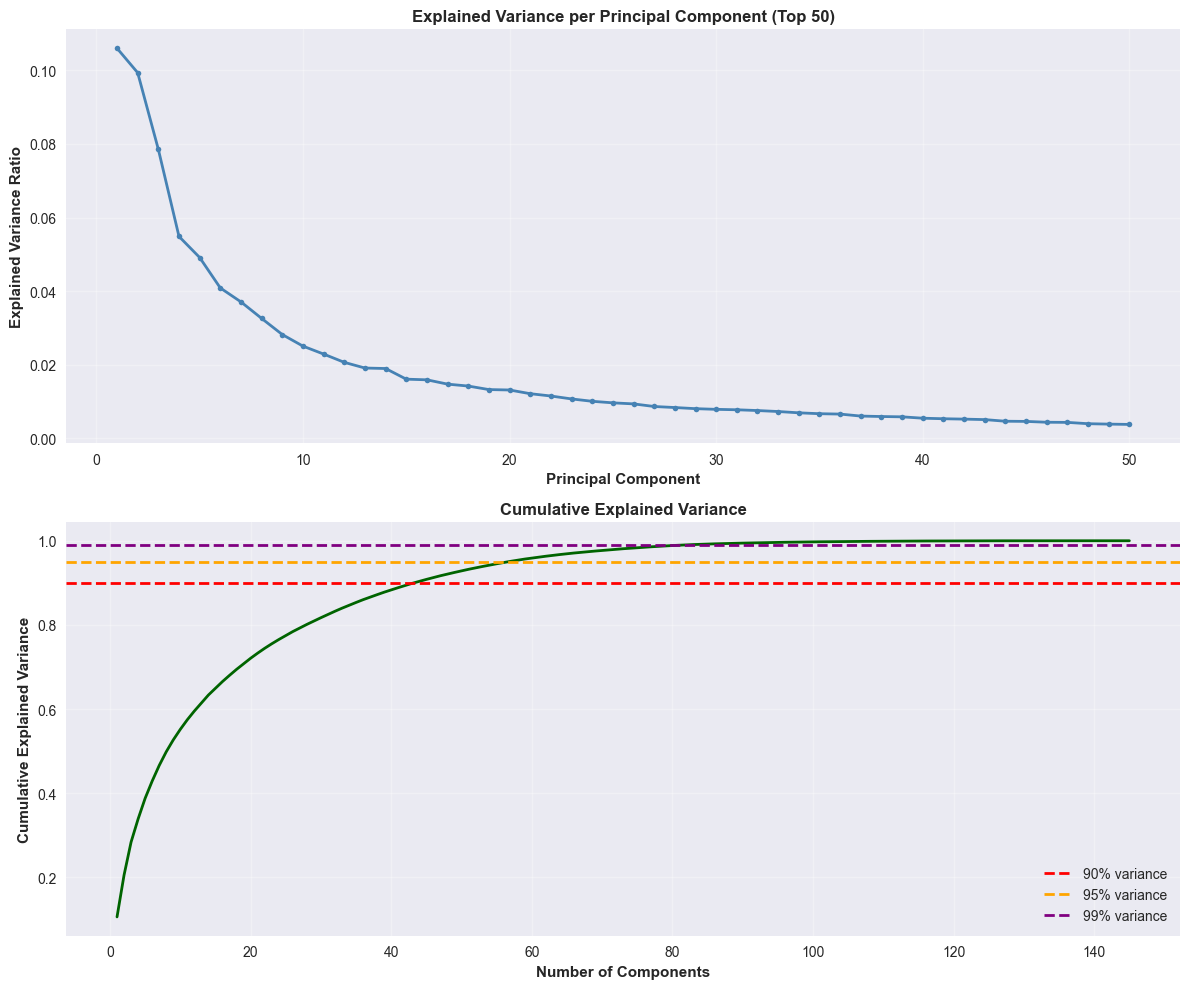

In [8]:
# Visualize PCA explained variance
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Explained variance per component
n_show = min(50, len(pca.explained_variance_ratio_))
axes[0].plot(range(1, n_show + 1), 
             pca.explained_variance_ratio_[:n_show], 'o-', linewidth=2, markersize=4, color='steelblue')
axes[0].set_xlabel('Principal Component', fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontweight='bold')
axes[0].set_title('Explained Variance per Principal Component (Top 50)', fontweight='bold', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, linewidth=2, color='darkgreen')
axes[1].axhline(0.90, color='red', linestyle='--', linewidth=2, label='90% variance')
axes[1].axhline(0.95, color='orange', linestyle='--', linewidth=2, label='95% variance')
axes[1].axhline(0.99, color='purple', linestyle='--', linewidth=2, label='99% variance')
axes[1].set_xlabel('Number of Components', fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontweight='bold')
axes[1].set_title('Cumulative Explained Variance', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Step 4: Compare Different Feature Selection Strategies


In [9]:
# Strategy 1: Top N features by Random Forest importance
def get_top_rf_features(n_features=30):
    top_features = feature_importance.head(n_features)['feature'].tolist()
    return top_features

# Strategy 2: PCA with N components (keeping 95% variance)
def get_pca_features(n_components=n_components_95):
    # PCA already applied, return transformed data
    return X_train_pca[:, :n_components], X_test_pca[:, :n_components], n_components

# Strategy 3: Hybrid - Top statistical features + PCA on EMD features
def get_hybrid_features(n_stat=10, n_pca_emd=20):
    # Top statistical features
    stat_importance = feature_importance[feature_importance['feature'].isin(stat_features)]
    top_stat = stat_importance.head(n_stat)['feature'].tolist()
    
    # Apply PCA to EMD features only
    emd_features_clean = [f for f in features_after_redundancy_removal if f in emd_features]
    X_train_emd_clean = X_train[emd_features_clean]
    X_test_emd_clean = X_test[emd_features_clean]
    
    scaler_emd = StandardScaler()
    X_train_emd_scaled = scaler_emd.fit_transform(X_train_emd_clean)
    X_test_emd_scaled = scaler_emd.transform(X_test_emd_clean)
    
    pca_emd = PCA(n_components=n_pca_emd)
    X_train_emd_pca = pca_emd.fit_transform(X_train_emd_scaled)
    X_test_emd_pca = pca_emd.transform(X_test_emd_scaled)
    
    # Combine: statistical features + PCA of EMD
    X_train_hybrid = np.hstack([X_train[top_stat].values, X_train_emd_pca])
    X_test_hybrid = np.hstack([X_test[top_stat].values, X_test_emd_pca])
    
    return X_train_hybrid, X_test_hybrid, top_stat + [f'emd_pc{i+1}' for i in range(n_pca_emd)]

print("✅ Feature selection strategies defined!")


✅ Feature selection strategies defined!


In [10]:
# Compare strategies by training Random Forest on each
strategies = {}

# Strategy 1: Top 30 RF features
top_30_features = get_top_rf_features(30)
X_train_strategy1 = X_train[top_30_features]
X_test_strategy1 = X_test[top_30_features]

rf_strategy1 = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_strategy1.fit(X_train_strategy1, y_train)
y_pred_strategy1 = rf_strategy1.predict(X_test_strategy1)

strategies['Top 30 RF Features'] = {
    'n_features': 30,
    'mae': mean_absolute_error(y_test, y_pred_strategy1),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_strategy1)),
    'r2': r2_score(y_test, y_pred_strategy1)
}

# Strategy 2: PCA (95% variance)
X_train_strategy2, X_test_strategy2, n_comp = get_pca_features(n_components_95)

rf_strategy2 = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_strategy2.fit(X_train_strategy2, y_train)
y_pred_strategy2 = rf_strategy2.predict(X_test_strategy2)

strategies['PCA (95% variance)'] = {
    'n_features': n_comp,
    'mae': mean_absolute_error(y_test, y_pred_strategy2),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_strategy2)),
    'r2': r2_score(y_test, y_pred_strategy2)
}

# Strategy 3: Hybrid (Top 10 stat + PCA on EMD)
X_train_strategy3, X_test_strategy3, hybrid_feature_names = get_hybrid_features(10, 20)

rf_strategy3 = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_strategy3.fit(X_train_strategy3, y_train)
y_pred_strategy3 = rf_strategy3.predict(X_test_strategy3)

strategies['Hybrid (10 stat + 20 PCA EMD)'] = {
    'n_features': 30,
    'mae': mean_absolute_error(y_test, y_pred_strategy3),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_strategy3)),
    'r2': r2_score(y_test, y_pred_strategy3)
}

# Baseline: All features
rf_baseline = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)
y_pred_baseline = rf_baseline.predict(X_test)

strategies['Baseline (All 175 features)'] = {
    'n_features': 175,
    'mae': mean_absolute_error(y_test, y_pred_baseline),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_baseline)),
    'r2': r2_score(y_test, y_pred_baseline)
}

# Display comparison
comparison_df = pd.DataFrame(strategies).T
comparison_df = comparison_df.round(3)
print("\n📊 Feature Selection Strategy Comparison:")
print(comparison_df.to_string())



📊 Feature Selection Strategy Comparison:
                               n_features     mae    rmse     r2
Top 30 RF Features                   30.0  21.935  28.783 -0.124
PCA (95% variance)                   57.0  20.110  24.925  0.157
Hybrid (10 stat + 20 PCA EMD)        30.0  22.291  29.036 -0.144
Baseline (All 175 features)         175.0  21.361  28.069 -0.069


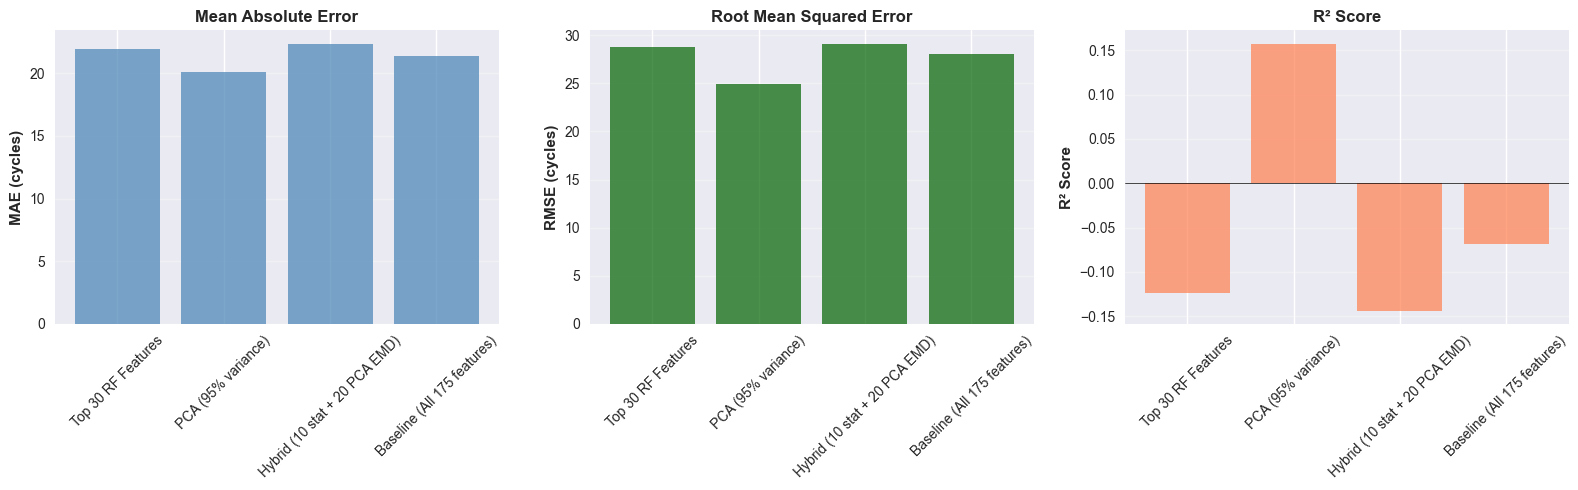

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

strategies_list = list(strategies.keys())
mae_values = [strategies[s]['mae'] for s in strategies_list]
rmse_values = [strategies[s]['rmse'] for s in strategies_list]
r2_values = [strategies[s]['r2'] for s in strategies_list]

axes[0].bar(strategies_list, mae_values, color='steelblue', alpha=0.7)
axes[0].set_ylabel('MAE (cycles)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(strategies_list, rmse_values, color='darkgreen', alpha=0.7)
axes[1].set_ylabel('RMSE (cycles)', fontweight='bold')
axes[1].set_title('Root Mean Squared Error', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(strategies_list, r2_values, color='coral', alpha=0.7)
axes[2].set_ylabel('R² Score', fontweight='bold')
axes[2].set_title('R² Score', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()


## Step 5: Save Selected Features and Transformers


In [14]:
# Choose best strategy (lowest MAE or highest R²)
best_strategy = min(strategies.items(), key=lambda x: x[1]['mae'])
print(f"\n🏆 Best Strategy: {best_strategy[0]}")
print(f"   MAE: {best_strategy[1]['mae']:.3f} cycles")
print(f"   RMSE: {best_strategy[1]['rmse']:.3f} cycles")
print(f"   R²: {best_strategy[1]['r2']:.3f}")
print(f"   Features: {best_strategy[1]['n_features']}")

# Save selected features based on best strategy
models_dir = project_root / "results" / "models"
models_dir.mkdir(parents=True, exist_ok=True)

selected_features = None
feature_selection_info = {}

if 'Top 30 RF Features' in best_strategy[0]:
    # Save top 30 features
    selected_features = top_30_features
    feature_selection_info = {
        'method': 'random_forest_importance',
        'n_features': 30,
        'features': selected_features,
        'strategy': 'Top 30 RF Features'
    }
    
elif 'PCA' in best_strategy[0] and 'Hybrid' not in best_strategy[0]:
    # Save PCA transformer
    selected_features = None  # PCA doesn't use original features
    feature_selection_info = {
        'method': 'pca',
        'n_components': int(n_components_95),  # Convert numpy int64 to Python int
        'features_after_redundancy_removal': features_after_redundancy_removal,
        'strategy': 'PCA (95% variance)'
    }
    
    # Save PCA and scaler
    joblib.dump(pca, models_dir / "feature_selection_pca.pkl")
    joblib.dump(scaler_pca, models_dir / "feature_selection_scaler.pkl")
    
elif 'Hybrid' in best_strategy[0]:
    # Save hybrid approach
    selected_features = hybrid_feature_names
    feature_selection_info = {
        'method': 'hybrid',
        'n_stat_features': 10,
        'n_pca_emd': 20,
        'stat_features': top_stat,
        'features': hybrid_feature_names,
        'strategy': 'Hybrid (10 stat + 20 PCA EMD)'
    }

# Save feature selection info
with open(models_dir / "feature_selection_info.json", 'w') as f:
    json.dump(feature_selection_info, f, indent=2)

print(f"\n✅ Saved feature selection info to {models_dir / 'feature_selection_info.json'}")

# Also save feature importance for reference
feature_importance.to_csv(models_dir / "feature_importance_analysis.csv", index=False)
print(f"✅ Saved feature importance analysis to {models_dir / 'feature_importance_analysis.csv'}")



🏆 Best Strategy: PCA (95% variance)
   MAE: 20.110 cycles
   RMSE: 24.925 cycles
   R²: 0.157
   Features: 57

✅ Saved feature selection info to /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/feature_selection_info.json
✅ Saved feature importance analysis to /Users/siddhantaggarwal/Desktop/Battery_RUL/results/models/feature_importance_analysis.csv


## Step 6: Summary and Recommendations


In [13]:
print("\n" + "="*80)
print("FEATURE SELECTION SUMMARY")
print("="*80)

print(f"\n📊 Original Features: {len(feature_cols)}")
print(f"   - Statistical: {len(stat_features)}")
print(f"   - EMD: {len(emd_features)}")

print(f"\n🔍 Redundancy Analysis:")
print(f"   - Highly correlated EMD pairs (>0.95): {len(high_corr_pairs)}")
print(f"   - Redundant features removed: {len(features_to_remove)}")
print(f"   - Features after redundancy removal: {len(features_after_redundancy_removal)}")

print(f"\n📉 PCA Analysis:")
print(f"   - Components for 90% variance: {n_components_90}")
print(f"   - Components for 95% variance: {n_components_95}")
print(f"   - Components for 99% variance: {n_components_99}")

print(f"\n🏆 Best Strategy: {best_strategy[0]}")
print(f"   - Features: {best_strategy[1]['n_features']}")
print(f"   - Test MAE: {best_strategy[1]['mae']:.3f} cycles")
print(f"   - Test RMSE: {best_strategy[1]['rmse']:.3f} cycles")
print(f"   - Test R²: {best_strategy[1]['r2']:.3f}")

print(f"\n📝 Next Steps:")
print(f"   1. Use selected features to retrain LSTM model")
print(f"   2. Compare performance: original (175 features) vs reduced ({best_strategy[1]['n_features']} features)")
print(f"   3. Update dashboard to use reduced feature set")
print(f"   4. Monitor if overfitting is reduced (train R² vs test R² gap)")

print("\n" + "="*80)



FEATURE SELECTION SUMMARY

📊 Original Features: 175
   - Statistical: 16
   - EMD: 159

🔍 Redundancy Analysis:
   - Highly correlated EMD pairs (>0.95): 68
   - Redundant features removed: 30
   - Features after redundancy removal: 145

📉 PCA Analysis:
   - Components for 90% variance: 44
   - Components for 95% variance: 57
   - Components for 99% variance: 82

🏆 Best Strategy: PCA (95% variance)
   - Features: 57
   - Test MAE: 20.110 cycles
   - Test RMSE: 24.925 cycles
   - Test R²: 0.157

📝 Next Steps:
   1. Use selected features to retrain LSTM model
   2. Compare performance: original (175 features) vs reduced (57 features)
   3. Update dashboard to use reduced feature set
   4. Monitor if overfitting is reduced (train R² vs test R² gap)

